In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [76]:
ops = pd.read_csv('AAPLOptions.csv')
ops['price'] = (ops['best_bid'] + ops['best_offer']) / 2
ops['strike_price'] = ops['strike_price'] / 1000

In [77]:
ops = ops.drop(['ticker', 'forward_price', 'index_flag', 'exercise_style', 'issuer', 'optionid', 'impl_volatility'], axis=1)

In [78]:
ops[['date', 'exdate']] = ops[['date', 'exdate']].apply(pd.to_datetime, format='%d/%m/%Y')

In [79]:
ops['dtm'] = ops['exdate'] - ops['date']

In [80]:
ops.head()

,date,exdate,cp_flag,strike_price,best_bid,best_offer,price,dtm
0,2012-09-04,2012-09-07,C,590.0,84.70,85.50,85.100,3 days
1,2012-09-04,2012-09-07,C,595.0,78.90,80.80,79.850,3 days
2,2012-09-04,2012-09-07,C,600.0,74.70,75.15,74.925,3 days
3,2012-09-04,2012-09-07,C,605.0,68.85,70.70,69.775,3 days
4,2012-09-04,2012-09-07,C,610.0,64.75,65.45,65.100,3 days


In [81]:
calls = ops[ops['cp_flag'] == 'C'].drop('cp_flag', axis=1).reset_index(drop=True)
puts = ops[ops['cp_flag'] == 'P'].drop('cp_flag', axis=1).reset_index(drop=True)
mostCalls = calls[calls['dtm'] == max(calls['dtm'])].drop('dtm', axis=1).reset_index(drop=True)
mostPuts = puts[puts['dtm'] == max(puts['dtm'])].drop('dtm', axis=1).reset_index(drop=True)

In [90]:
firstCall = mostCalls[mostCalls['exdate'] == mostCalls['exdate'].iloc[0]]
firstCall.sort_values('date')
firstCall.head()

,date,exdate,strike_price,best_bid,best_offer,price
0,2019-01-15,2021-06-18,100.0,56.05,61.0,58.525
1,2019-01-15,2021-06-18,105.0,52.05,57.0,54.525
2,2019-01-15,2021-06-18,110.0,48.55,53.5,51.025
3,2019-01-15,2021-06-18,115.0,45.50,50.0,47.750
4,2019-01-15,2021-06-18,120.0,42.00,47.0,44.500


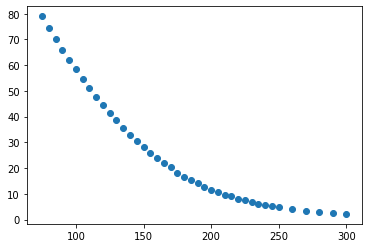

In [136]:
plt.scatter(firstCall['strike_price'], firstCall['price'])

In [137]:
def coskew(df):
    v = df.values
    s1 = sigma = v.std(0, keepdims=True)
    means = v.mean(0, keepdims=True)

    # means is 1 x n (n is number of columns
    # this difference broacasts appropriately
    v1 = v - means

    s2 = sigma ** 2

    v2 = v1 ** 2

    m = v.shape[0]

    skew = pd.DataFrame(v2.T.dot(v1) / s2.T.dot(s1) / m, df.columns, df.columns)
    skew *= ((m - 1) * m) ** .5 / (m - 2)

    return skew

In [139]:
def cokurt(df, bias=False, variant='middle'):
    v = df.values
    s1 = sigma = v.std(0, keepdims=True)
    means = v.mean(0, keepdims=True)

    # means is 1 x n (n is number of columns
    # this difference broacasts appropriately
    v1 = v - means

    s2 = sigma ** 2
    s3 = sigma ** 3

    v2 = v1 ** 2
    v3 = v1 ** 3

    m = v.shape[0]

    if variant in ['left', 'right']:
        kurt = pd.DataFrame(v3.T.dot(v1) / s3.T.dot(s1) / m, df.columns, df.columns)
        if variant == 'right':
            kurt = kurt.T
    elif variant == 'middle':
        kurt = pd.DataFrame(v2.T.dot(v2) / s2.T.dot(s2) / m, df.columns, df.columns)

    if not bias:
        kurt = kurt * (m ** 2 - 1) / (m - 2) / (m - 3) - 3 * (m - 1) ** 2 / (m - 2) / (m - 3)
    
    kurt += 3

    return kurt